In [58]:
import numpy as np
import os

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE


from pymongo import MongoClient

import datetime
import pandas as pd

import sys
sys.path.append('../..')

import utils.dbUtils

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [59]:
client = MongoClient('192.168.178.25', 27017)
db = client.TFE
collection = db.results

In [60]:
train = utils.dbUtils.TokenizedIterator('liar_liar', filters = {'split' : {'$in' : ['train', 'valid']}})
y_train = np.array([x for x in train.iterTags()])

test = utils.dbUtils.TokenizedIterator('liar_liar', filters = {'split' : 'test'})
y_test = np.array([x for x in test.iterTags()])

In [61]:
vectorizer = TfidfVectorizer(max_features = 500)
X_train = vectorizer.fit_transform([' '.join(news) for news in train])
X_test = vectorizer.transform([' '.join(news) for news in test])
svc = LinearSVC(C = 0.1)
svc.fit(X_train, y_train)

roc1 = roc_curve(y_test, svc.decision_function(X_test), pos_label='fake')
auc1 = roc_auc_score(y_test, svc.decision_function(X_test))
clr1 = pd.DataFrame(classification_report(y_test, svc.predict(X_test), output_dict = True))
cm1 = confusion_matrix(y_test, svc.predict(X_test), labels = ['fake', 'reliable'])

ridge = RidgeClassifier(alpha=10)
ridge.fit(X_train, y_train)
roc3 = roc_curve(y_test, ridge.decision_function(X_test), pos_label='fake')
auc3 = roc_auc_score(y_test, ridge.decision_function(X_test))
clr3 = pd.DataFrame(classification_report(y_test, ridge.predict(X_test), output_dict = True))
cm3 = confusion_matrix(y_test, ridge.predict(X_test), labels = ['fake', 'reliable'])


vectorizer = TfidfVectorizer(max_features = None)
X_train = vectorizer.fit_transform([' '.join(news) for news in train])
X_test = vectorizer.transform([' '.join(news) for news in test])
dt = DecisionTreeClassifier(max_depth=1000)
dt.fit(X_train, y_train)

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [62]:
y_score = dt.predict_proba(X_test)
roc2 = roc_curve(y_test, y_score[:,1], pos_label='fake')
auc2 = roc_auc_score(y_test, y_score[:,1])
clr2 = pd.DataFrame(classification_report(y_test, nb.predict(X_test), output_dict = True))
cm2 = confusion_matrix(y_test, nb.predict(X_test), labels = ['fake', 'reliable'])

y_score = nb.predict_proba(X_test)
roc4 = roc_curve(y_test, y_score[:,1], pos_label='fake')
auc4 = roc_auc_score(y_test, y_score[:,1])
clr4 = pd.DataFrame(classification_report(y_test, dt.predict(X_test), output_dict = True))
cm4 = confusion_matrix(y_test, dt.predict(X_test), labels = ['fake', 'reliable'])

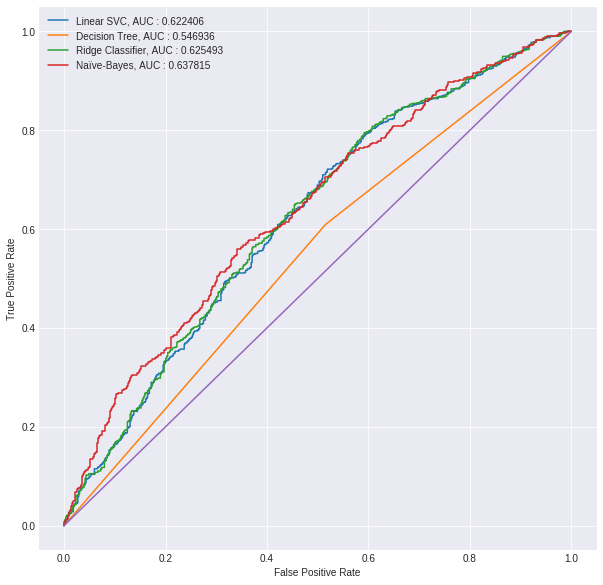

In [63]:
plt.figure(figsize = (10,10))
plt.plot(roc1[1], roc1[0], label = 'Linear SVC, AUC : {:4f}'.format(auc1))
plt.plot(roc2[1], roc2[0], label = 'Decision Tree, AUC : {:4f}'.format(auc2))
plt.plot(roc3[1], roc3[0], label = 'Ridge Classifier, AUC : {:4f}'.format(auc3))
plt.plot(roc4[1], roc4[0], label = 'Naïve-Bayes, AUC : {:4f}'.format(auc4))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot([0, 1], [0, 1])
plt.savefig('output/roc1.pdf')

In [64]:
print("Classification Report")
print("Linear SVM")
print(clr1)
print("Naïve-Bayes")
print(clr2)
print("Ridge Classifier")
print(clr3)
print("Decision Tree")
print(clr4)
for i, df in enumerate([clr1, clr2, clr3, clr4]):
    fp = open('clr{}.tex'.format(i), 'w')
    df.to_latex(fp)
    fp.close()

Classification Report
Linear SVM
                  fake     reliable  accuracy    macro avg  weighted avg
f1-score      0.514399     0.679764  0.614049     0.597082      0.607588
precision     0.570485     0.638376  0.614049     0.604430      0.608744
recall        0.468354     0.726891  0.614049     0.597623      0.614049
support    1106.000000  1428.000000  0.614049  2534.000000   2534.000000
Naïve-Bayes
                  fake     reliable  accuracy    macro avg  weighted avg
f1-score      0.412107     0.698507  0.601421     0.555307      0.573504
precision     0.578431     0.608741  0.601421     0.593586      0.595512
recall        0.320072     0.819328  0.601421     0.569700      0.601421
support    1106.000000  1428.000000  0.601421  2534.000000   2534.000000
Ridge Classifier
                  fake     reliable  accuracy    macro avg  weighted avg
f1-score      0.496366     0.691279  0.617206     0.593822      0.606207
precision     0.582927     0.633606  0.617206     0.608266    

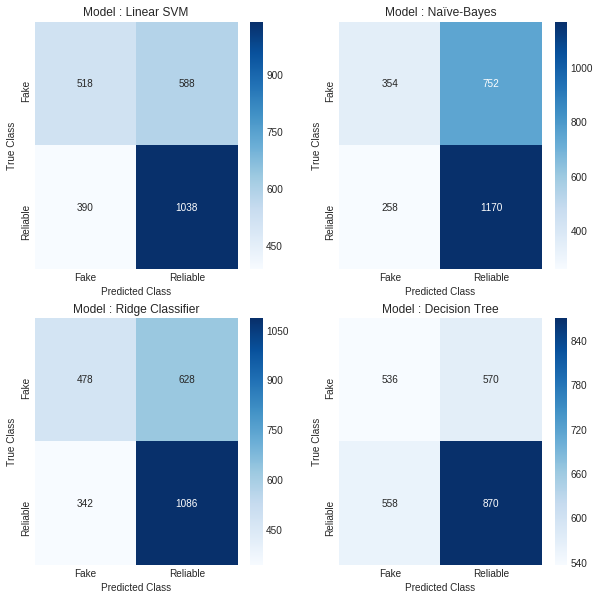

In [65]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
#fig.suptitle("Confusion Matrix")
for i, (cm, model) in enumerate(list(zip([cm1, cm2, cm3, cm4], ['Linear SVM', 'Naïve-Bayes', 'Ridge Classifier', 'Decision Tree']))):
        df = pd.DataFrame(cm, index = ['Fake', 'Reliable'], columns = ['Fake', 'Reliable'])
        sns.heatmap(df, annot=True, cmap="Blues", ax = axes.flat[i], fmt='g')
        axes.flat[i].set_title('Model : {}'.format(model))
        axes.flat[i].set_xlabel('Predicted Class')
        axes.flat[i].set_ylabel('True Class')
plt.savefig('output/test_liar_confMat.pdf')

In [40]:
train = utils.dbUtils.TokenizedIterator('news_cleaned', filters = {'split' : {'$in' : ['train', 'valid']}})
y_train = np.array([x for x in train.iterTags()])

test = utils.dbUtils.TokenizedIterator('news_cleaned', filters = {'split' : 'test'})
y_test = np.array([x for x in test.iterTags()])

In [43]:
vectorizer = TfidfVectorizer(max_features = 100000)
X_train = vectorizer.fit_transform([' '.join(news) for news in train])
X_test = vectorizer.transform([' '.join(news) for news in test])
svc = LinearSVC(C = 1)
svc.fit(X_train, y_train)

roc1 = roc_curve(y_test, svc.decision_function(X_test), pos_label='fake')
auc1 = roc_auc_score(y_test, svc.decision_function(X_test))
clr1 = pd.DataFrame(classification_report(y_test, svc.predict(X_test), output_dict = True))
cm1 = confusion_matrix(y_test, svc.predict(X_test), labels = ['fake', 'reliable'])

ridge = RidgeClassifier(alpha=1)
ridge.fit(X_train, y_train)
roc3 = roc_curve(y_test, ridge.decision_function(X_test), pos_label='fake')
auc3 = roc_auc_score(y_test, ridge.decision_function(X_test))
clr3 = pd.DataFrame(classification_report(y_test, ridge.predict(X_test), output_dict = True))
cm3 = confusion_matrix(y_test, ridge.predict(X_test), labels = ['fake', 'reliable'])

dt = DecisionTreeClassifier(max_depth=100)
dt.fit(X_train, y_train)

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [44]:
y_score = dt.predict_proba(X_test)
roc2 = roc_curve(y_test, y_score[:,1], pos_label='fake')
auc2 = roc_auc_score(y_test, y_score[:,1])
clr2 = pd.DataFrame(classification_report(y_test, nb.predict(X_test), output_dict = True))
cm2 = confusion_matrix(y_test, nb.predict(X_test), labels = ['fake', 'reliable'])

y_score = nb.predict_proba(X_test)
roc4 = roc_curve(y_test, y_score[:,1], pos_label='fake')
auc4 = roc_auc_score(y_test, y_score[:,1])
clr4 = pd.DataFrame(classification_report(y_test, dt.predict(X_test), output_dict = True))
cm4 = confusion_matrix(y_test, dt.predict(X_test), labels = ['fake', 'reliable'])

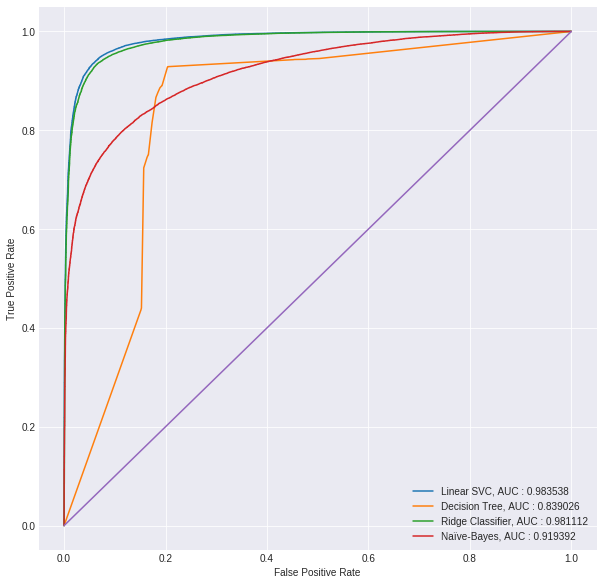

In [45]:
plt.figure(figsize = (10,10))
plt.plot(roc1[1], roc1[0], label = 'Linear SVC, AUC : {:4f}'.format(auc1))
plt.plot(roc2[1], roc2[0], label = 'Decision Tree, AUC : {:4f}'.format(auc2))
plt.plot(roc3[1], roc3[0], label = 'Ridge Classifier, AUC : {:4f}'.format(auc3))
plt.plot(roc4[1], roc4[0], label = 'Naïve-Bayes, AUC : {:4f}'.format(auc4))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot([0, 1], [0, 1])
plt.savefig('output/roc2.pdf')

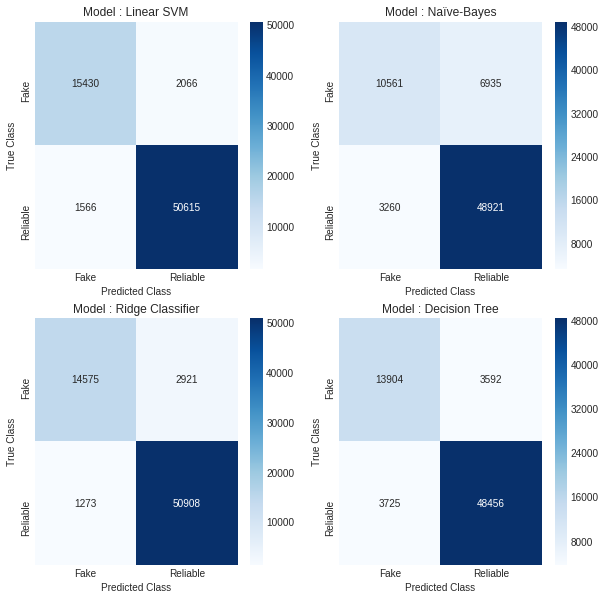

In [49]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
#fig.suptitle("Confusion Matrix")
for i, (cm, model) in enumerate(list(zip([cm1, cm2, cm3, cm4], ['Linear SVM', 'Naïve-Bayes', 'Ridge Classifier', 'Decision Tree']))):
        df = pd.DataFrame(cm, index = ['Fake', 'Reliable'], columns = ['Fake', 'Reliable'])
        sns.heatmap(df, annot=True, cmap="Blues", ax = axes.flat[i], fmt='g')
        axes.flat[i].set_title('Model : {}'.format(model))
        axes.flat[i].set_xlabel('Predicted Class')
        axes.flat[i].set_ylabel('True Class')
plt.savefig('output/test_fake_confMat.pdf')

In [50]:
print("Classification Report")
print("Linear SVM")
print(clr1)
print("Naïve-Bayes")
print(clr2)
print("Ridge Classifier")
print(clr3)
print("Decision Tree")
print(clr4)
for i, df in enumerate([clr1, clr2, clr3, clr4]):
    fp = open('clr{}.2.tex'.format(i), 'w')
    df.to_latex(fp)
    fp.close()

Classification Report
Linear SVM
                   fake      reliable  accuracy     macro avg  weighted avg
f1-score       0.894700      0.965364  0.947874      0.930032      0.947620
precision      0.907861      0.960783  0.947874      0.934322      0.947494
recall         0.881916      0.969989  0.947874      0.925952      0.947874
support    17496.000000  52181.000000  0.947874  69677.000000  69677.000000
Naïve-Bayes
                   fake      reliable  accuracy     macro avg  weighted avg
f1-score       0.674458      0.905634  0.853682      0.790046      0.847585
precision      0.764127      0.875841  0.853682      0.819984      0.847790
recall         0.603624      0.937525  0.853682      0.770574      0.853682
support    17496.000000  52181.000000  0.853682  69677.000000  69677.000000
Ridge Classifier
                   fake      reliable  accuracy     macro avg  weighted avg
f1-score       0.874220      0.960438  0.939808      0.917329      0.938788
precision      0.919674   

In [53]:
vectorizer = TfidfVectorizer(max_features = 100000)
X_train = vectorizer.fit_transform([' '.join(news) for news in train])
X_test = vectorizer.transform([' '.join(news) for news in test])
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

svc = LinearSVC(C = 1)
svc.fit(X_res, y_res)

roc1 = roc_curve(y_test, svc.decision_function(X_test), pos_label='fake')
auc1 = roc_auc_score(y_test, svc.decision_function(X_test))
clr1 = pd.DataFrame(classification_report(y_test, svc.predict(X_test), output_dict = True))
cm1 = confusion_matrix(y_test, svc.predict(X_test), labels = ['fake', 'reliable'])

ridge = RidgeClassifier(alpha=1)
ridge.fit(X_res, y_res)
roc3 = roc_curve(y_test, ridge.decision_function(X_test), pos_label='fake')
auc3 = roc_auc_score(y_test, ridge.decision_function(X_test))
clr3 = pd.DataFrame(classification_report(y_test, ridge.predict(X_test), output_dict = True))
cm3 = confusion_matrix(y_test, ridge.predict(X_test), labels = ['fake', 'reliable'])

dt = DecisionTreeClassifier(max_depth=100)
dt.fit(X_res, y_res)

nb = MultinomialNB()
nb.fit(X_res, y_res)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [54]:
y_score = dt.predict_proba(X_test)
roc2 = roc_curve(y_test, y_score[:,1], pos_label='fake')
auc2 = roc_auc_score(y_test, y_score[:,1])
clr2 = pd.DataFrame(classification_report(y_test, nb.predict(X_test), output_dict = True))
cm2 = confusion_matrix(y_test, nb.predict(X_test), labels = ['fake', 'reliable'])

y_score = nb.predict_proba(X_test)
roc4 = roc_curve(y_test, y_score[:,1], pos_label='fake')
auc4 = roc_auc_score(y_test, y_score[:,1])
clr4 = pd.DataFrame(classification_report(y_test, dt.predict(X_test), output_dict = True))
cm4 = confusion_matrix(y_test, dt.predict(X_test), labels = ['fake', 'reliable'])

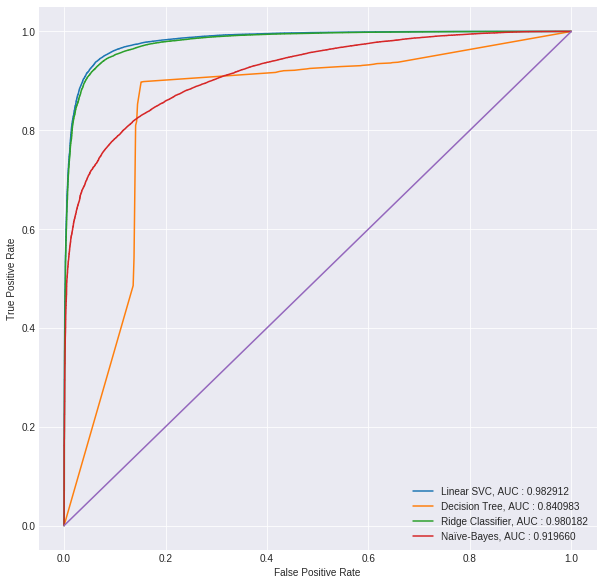

In [55]:
plt.figure(figsize = (10,10))
plt.plot(roc1[1], roc1[0], label = 'Linear SVC, AUC : {:4f}'.format(auc1))
plt.plot(roc2[1], roc2[0], label = 'Decision Tree, AUC : {:4f}'.format(auc2))
plt.plot(roc3[1], roc3[0], label = 'Ridge Classifier, AUC : {:4f}'.format(auc3))
plt.plot(roc4[1], roc4[0], label = 'Naïve-Bayes, AUC : {:4f}'.format(auc4))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot([0, 1], [0, 1])
plt.savefig('output/roc3.pdf')

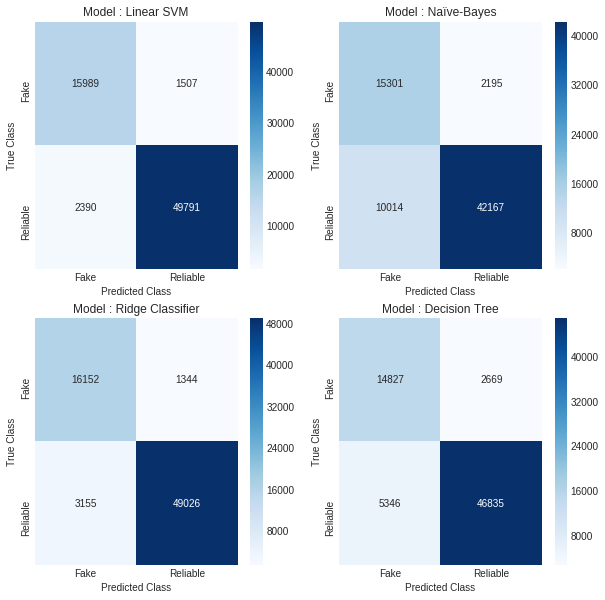

In [56]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
#fig.suptitle("Confusion Matrix")
for i, (cm, model) in enumerate(list(zip([cm1, cm2, cm3, cm4], ['Linear SVM', 'Naïve-Bayes', 'Ridge Classifier', 'Decision Tree']))):
        df = pd.DataFrame(cm, index = ['Fake', 'Reliable'], columns = ['Fake', 'Reliable'])
        sns.heatmap(df, annot=True, cmap="Blues", ax = axes.flat[i], fmt='g')
        axes.flat[i].set_title('Model : {}'.format(model))
        axes.flat[i].set_xlabel('Predicted Class')
        axes.flat[i].set_ylabel('True Class')
plt.savefig('output/test_SMOTE_fake_confMat.pdf')

In [57]:
print("Classification Report")
print("Linear SVM")
print(clr1)
print("Naïve-Bayes")
print(clr2)
print("Ridge Classifier")
print(clr3)
print("Decision Tree")
print(clr4)
for i, df in enumerate([clr1, clr2, clr3, clr4]):
    fp = open('clr{}.3.tex'.format(i), 'w')
    df.to_latex(fp)
    fp.close()

Classification Report
Linear SVM
                   fake      reliable  accuracy     macro avg  weighted avg
f1-score       0.891373      0.962340   0.94407      0.926857      0.944520
precision      0.869960      0.970623   0.94407      0.920291      0.945346
recall         0.913866      0.954198   0.94407      0.934032      0.944070
support    17496.000000  52181.000000   0.94407  69677.000000  69677.000000
Naïve-Bayes
                   fake      reliable  accuracy     macro avg  weighted avg
f1-score       0.714816      0.873538  0.824777      0.794177      0.833683
precision      0.604424      0.950521  0.824777      0.777472      0.863615
recall         0.874543      0.808091  0.824777      0.841317      0.824777
support    17496.000000  52181.000000  0.824777  69677.000000  69677.000000
Ridge Classifier
                   fake      reliable  accuracy     macro avg  weighted avg
f1-score       0.877755      0.956129  0.935431      0.916942      0.936449
precision      0.836588   